<a href="https://colab.research.google.com/github/obeabi/Stocks_TSA/blob/main/StockPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [198]:
!pip install pandas_ta


In [199]:
import logging
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Importing the Keras libraries and packages
import keras
print(keras.__version__)
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

2.15.0


## Fetch & Load the data

In [200]:
# Fetch historical stock data using yfinance
ticker = 'VNO'
start_date , end_date = '2021-01-01' , '2024-01-09'

df = yf.download(ticker, start=start_date, end= end_date)

# Calculate technical indicators (RSI, MACD, ATR, Bolinger Bands) using pandas_ta
df.ta.rsi(close="Close", append=True)
df.ta.macd(close="Close", append=True)
df.ta.atr(length=14, append=True)
df.ta.bbands(append=True)

# Fetch Federal Funds Rate data from FRED
fed_funds_rate = web.DataReader("FEDFUNDS", "fred", start_date, end_date)

# Fetch Consumer Price Index (CPI) data from FRED
cpi_data = web.DataReader("CPIAUCNS", "fred", start_date, end_date)

# Fetch VIX data from Yahoo Finance using yfinance
vix_data = yf.download("^VIX", start=start_date, end=end_date)

# Rename the 'Adj Close' column to 'VIX' for consistency
vix_data = vix_data.rename(columns={'Adj Close': 'VIX'})

# Fetch Nonfarm Payrolls data from FRED using pandas_datareader
nfp_data = web.DataReader("PAYEMS", "fred", start_date, end_date)

# Rename the column to 'Nonfarm Payrolls' for consistency
nfp_data = nfp_data.rename(columns={'PAYEMS': 'Nonfarm Payrolls'})

# Ensure both DataFrames have the same frequency (daily for stock data, monthly for NFP data)
df = df.resample('D').last()
vix_data = vix_data.resample('D').last()
cpi_data = cpi_data.resample('M').last()
nfp_data = nfp_data.resample('M').last()
fed_funds_rate = fed_funds_rate.resample('M').last()


# Merge the stock_data DataFrame with the VIX data
df = pd.merge(df, vix_data['VIX'], how='left', left_index=True, right_index=True)


# Merge the stock_data DataFrame with the Federal Funds Rate data
df = pd.merge(df, fed_funds_rate, how='left', left_index=True, right_index=True)

# Forward fill the FEDFUNDS column to fill missing daily values
df['FEDFUNDS'] = df['FEDFUNDS'].ffill()

# Merge the stock_data DataFrame with the CPI data
df = pd.merge(df, cpi_data, how='left', left_index=True, right_index=True)

# Forward fill the CPIAUCNS column to fill missing daily values
df['CPIAUCNS'] = df['CPIAUCNS'].ffill()

# Merge the stock_data DataFrame with the Nonfarm Payrolls data
df = pd.merge(df, nfp_data, how='left', left_index=True, right_index=True)

# Forward fill the Nonfarm Payrolls column to fill missing daily values
df['Nonfarm Payrolls'] = df['Nonfarm Payrolls'].ffill()

# Drop rows with missing values in the index
df = df.dropna(subset=None)

df.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,ATRr_14,BBL_5_2.0,BBM_5_2.0,BBU_5_2.0,BBB_5_2.0,BBP_5_2.0,VIX,FEDFUNDS,CPIAUCNS,Nonfarm Payrolls
Date,,,,,,,,,,,,,,,,,,,,
2021-02-22,37.450001,40.709999,37.450001,40.680000,35.587067,4216500.0,63.243048,0.246813,-0.013525,0.260338,1.453234,34.646426,37.726000,40.805574,16.326005,0.979612,23.450001,0.09,261.582,142969.0
2021-02-23,41.000000,43.540001,40.310001,42.849998,37.485394,4390800.0,69.570868,0.607202,0.277491,0.329711,1.591254,33.751353,38.816000,43.880647,26.095667,0.898251,23.110001,0.09,261.582,142969.0
2021-02-24,42.900002,44.990002,42.810001,44.599998,39.016300,2586500.0,73.528667,1.022239,0.554023,0.468217,1.636704,33.884377,40.307999,46.731622,31.872694,0.834079,21.340000,0.09,261.582,142969.0
2021-02-25,44.730000,45.590000,42.200001,42.689999,37.345425,2899100.0,63.778375,1.183397,0.572144,0.611253,1.771279,36.592565,41.613999,46.635434,24.133390,0.607141,28.889999,0.09,261.582,142969.0
2021-02-26,42.740002,43.470001,42.169998,42.939999,37.564117,2773300.0,64.443001,1.316117,0.563891,0.752226,1.735298,40.260883,42.751999,45.243115,11.653798,0.537734,27.950001,0.09,261.582,142969.0


In [201]:
# Assuming df is your DataFrame with a 'Date' column

# Determine the split index based on the last two days
split_index = len(df) - 10

# Split the DataFrame into training and test sets
dataset_train = df.iloc[:split_index]
dataset_test  = df.iloc[split_index:]


dataset_train.head()

,Open,High,Low,Close,Adj Close,Volume,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,ATRr_14,BBL_5_2.0,BBM_5_2.0,BBU_5_2.0,BBB_5_2.0,BBP_5_2.0,VIX,FEDFUNDS,CPIAUCNS,Nonfarm Payrolls
Date,,,,,,,,,,,,,,,,,,,,
2021-02-22,37.450001,40.709999,37.450001,40.680000,35.587067,4216500.0,63.243048,0.246813,-0.013525,0.260338,1.453234,34.646426,37.726000,40.805574,16.326005,0.979612,23.450001,0.09,261.582,142969.0
2021-02-23,41.000000,43.540001,40.310001,42.849998,37.485394,4390800.0,69.570868,0.607202,0.277491,0.329711,1.591254,33.751353,38.816000,43.880647,26.095667,0.898251,23.110001,0.09,261.582,142969.0
2021-02-24,42.900002,44.990002,42.810001,44.599998,39.016300,2586500.0,73.528667,1.022239,0.554023,0.468217,1.636704,33.884377,40.307999,46.731622,31.872694,0.834079,21.340000,0.09,261.582,142969.0
2021-02-25,44.730000,45.590000,42.200001,42.689999,37.345425,2899100.0,63.778375,1.183397,0.572144,0.611253,1.771279,36.592565,41.613999,46.635434,24.133390,0.607141,28.889999,0.09,261.582,142969.0
2021-02-26,42.740002,43.470001,42.169998,42.939999,37.564117,2773300.0,64.443001,1.316117,0.563891,0.752226,1.735298,40.260883,42.751999,45.243115,11.653798,0.537734,27.950001,0.09,261.582,142969.0


In [202]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'RSI_14',
       'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'ATRr_14',
       'BBL_5_2.0', 'BBM_5_2.0', 'BBU_5_2.0', 'BBB_5_2.0', 'BBP_5_2.0', 'VIX',
       'FEDFUNDS', 'CPIAUCNS', 'Nonfarm Payrolls'],
      dtype='object')

In [203]:
# Specify the names of the two columns
column1 = 'Open'
column2 = 'Close'

# Create a new column with the average
#dataset_train['Open'] = dataset_train[[column1, column2]].mean(axis=1)
#dataset_test['Open'] = dataset_test[[column1, column2]].mean(axis=1)

# You can use 'Open' rather than 'Price'
features = ['Open','Close', 'Volume', 'RSI_14','VIX']
#features = ['Open', 'Close', 'Volume']
#features = ['Open','price', 'Close', 'Volume', 'RSI_14', 'MACD_12_26_9', 'MACDh_12_26_9','MACDs_12_26_9', 'ATRr_14', 'VIX', 'FEDFUNDS', 'CPIAUCNS']

dataset_train= dataset_train[features].copy()
dataset_test= dataset_test[features].copy()
no_indicators = len(features)


# Drop rows with missing data
dataset_train.dropna(inplace= True)
# Fill missing values in columns 'A' and 'B' using backfill
#columns_to_fill = features
#dataset_train[columns_to_fill] = dataset_train[columns_to_fill].fillna(method='bfill')

# Columns to be scaled (excluding Federal Funds Rate)
#columns_to_scale = ['Open', 'Volume', 'RSI_14', 'VIX']

train_features = dataset_train.iloc[:, 0:].values


dataset_train.head()

,Open,Close,Volume,RSI_14,VIX
Date,,,,,
2021-02-22,37.450001,40.680000,4216500.0,63.243048,23.450001
2021-02-23,41.000000,42.849998,4390800.0,69.570868,23.110001
2021-02-24,42.900002,44.599998,2586500.0,73.528667,21.340000
2021-02-25,44.730000,42.689999,2899100.0,63.778375,28.889999
2021-02-26,42.740002,42.939999,2773300.0,64.443001,27.950001


### Feature Scaling

In [204]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train_features)

print("The length of the sacled data is :" ,len(training_set_scaled) )
print()
training_set_scaled[0:5]

The length of the sacled data is : 715



array([[0.6585174 , 0.74670188, 0.06150734, 0.77967014, 0.46677607],
       [0.7518402 , 0.80395777, 0.06439492, 0.87896502, 0.45283021],
       [0.80178766, 0.85013191, 0.03450355, 0.94107002, 0.3802297 ],
       [0.84989487, 0.79973614, 0.03968232, 0.78807038, 0.68990972],
       [0.79758157, 0.80633244, 0.03759822, 0.79849956, 0.65135358]])

### Creating a data structure with 180 timesteps and 1 output

In [205]:
day_lag = 60
X_train = []
y_train = []
for i in range(day_lag, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-day_lag:i, 0:])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping the dataset to add more indicators

In [206]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], no_indicators))

In [207]:
print("Shape of X_train after reshaping:", X_train.shape)

Shape of X_train after reshaping: (655, 60, 5)


## Part 2 - Building and Training the RNN

### Initialising the RNN

In [208]:
regressor = Sequential()

### Adding the first LSTM layer and some Dropout regularisation

In [209]:
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], no_indicators)))
regressor.add(Dropout(0.2))

### Adding a second LSTM layer and some Dropout regularisation

In [210]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

### Adding a third LSTM layer and some Dropout regularisation

In [211]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

### Adding a fourth LSTM layer and some Dropout regularisation

In [212]:
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

### Adding the output layer

In [213]:
regressor.add(Dense(units = 1))

### Compiling the RNN

In [214]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

### Fitting the RNN to the Training set

In [215]:
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
21/21 [==============================] - 24s 289ms/step - loss: 0.0572
Epoch 2/100
21/21 [==============================] - 5s 219ms/step - loss: 0.0098
Epoch 3/100
21/21 [==============================] - 4s 172ms/step - loss: 0.0084
Epoch 4/100
21/21 [==============================] - 4s 175ms/step - loss: 0.0074
Epoch 5/100
21/21 [==============================] - 3s 119ms/step - loss: 0.0070
Epoch 6/100
21/21 [==============================] - 2s 101ms/step - loss: 0.0066
Epoch 7/100
21/21 [==============================] - 2s 103ms/step - loss: 0.0065
Epoch 8/100
21/21 [==============================] - 2s 105ms/step - loss: 0.0066
Epoch 9/100
21/21 [==============================] - 3s 124ms/step - loss: 0.0058
Epoch 10/100
21/21 [==============================] - 3s 161ms/step - loss: 0.0052
Epoch 11/100
21/21 [==============================] - 2s 111ms/step - loss: 0.0057
Epoch 12/100
21/21 [==============================] - 2s 110ms/step - loss: 0.0069
Epoch 13/100

## Part 3 - Making the predictions and visualising the results

In [216]:
# Drop rows with missing data
#dataset_test[columns_to_fill] = dataset_test[columns_to_fill].fillna(method='bfill')
dataset_test.head()

,Open,Close,Volume,RSI_14,VIX
Date,,,,,
2023-12-22,30.010000,29.170000,2905000.0,61.522877,13.03
2023-12-26,29.299999,30.139999,2934300.0,64.932848,12.99
2023-12-27,29.980000,29.090000,2686700.0,58.852667,12.43
2023-12-28,28.740000,29.389999,1224200.0,60.004989,12.47
2023-12-29,29.180000,28.250000,3256100.0,53.835236,12.45


In [217]:
# Plot a line chart using Plotly Express
fig = px.line(dataset_test, x=dataset_test.index, y='Open', title='Stock Price Over Time')

# Show the plot
fig.show()

In [218]:
# if Open price use this
real_stock_price = dataset_test.iloc[:, 0:1].values

# if Avergae price use this
#real_stock_price = dataset_test.iloc[:, -1:].values
real_stock_price[0:5]

array([[30.01000023],
       [29.29999924],
       [29.97999954],
       [28.73999977],
       [29.18000031]])

In [219]:
len(dataset_test)

10

### Getting the predicted stock price

In [220]:
# You can use 'Open'rather than 'Price'
dataset_total = pd.concat((dataset_train[features], dataset_test[features]), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - day_lag : ].values
print("Shape of inputs before reshaping:", inputs.shape)
inputs = inputs.reshape(-1,no_indicators)
print("\nShape of inputs after reshaping:", inputs.shape)
inputs = sc.transform(inputs)

# Account for the 3D structure required by the LSTM
X_test = []
for i in range(day_lag, day_lag + len(dataset_test)):
    X_test.append(inputs[i-day_lag:i, 0:])


X_test = np.array(X_test)
print("Shape of X_test before reshaping:", X_test.shape)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], no_indicators))
print("\nShape of X_test after reshaping:", X_test.shape)
predicted_stock_price = regressor.predict(X_test)


# Concatenate each entry with zero individually
# Replace `x` with the desired number of zeros
num_zeros = no_indicators- 1
predicted_stock_price = np.array([np.concatenate((entry, np.zeros(num_zeros))) for entry in predicted_stock_price])



# Apply inverse_transform to concatenated_results
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# Extract the first element from each entry (model predictions)
model_predictions = predicted_stock_price[:, 0]


Shape of inputs before reshaping: (70, 5)

Shape of inputs after reshaping: (70, 5)
Shape of X_test before reshaping: (10, 60, 5)

Shape of X_test after reshaping: (10, 60, 5)
1/1 [==============================] - 3s 3s/step


### Visualising the results

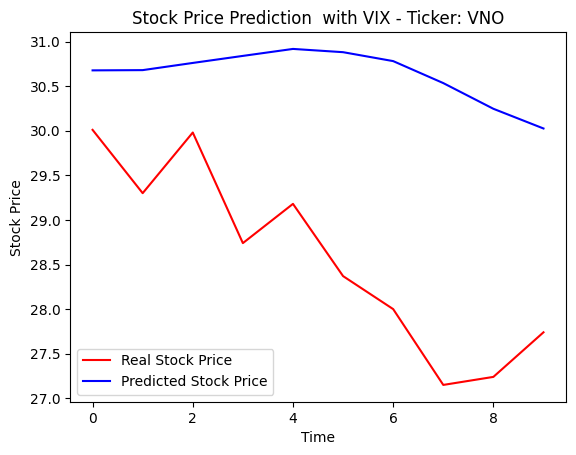

In [221]:
plt.plot(real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(model_predictions , color = 'blue', label = 'Predicted Stock Price')
plt.title(f'Stock Price Prediction  with VIX - Ticker: {ticker}')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()